## Кейс №1 - Приложение знакомств

### Общее описание:

В данных находится выгрузка логов взаимодействия пользователей друг с другом в приложении для онлайн-знакомств. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч. Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет. Нужно оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

#### Описание данных

* `user_id_1`, `user_id_2` - пара пользователей
* `group` - группы пользователей для АБ-теста, группа с номером `0` пользовалась приложением со старым алгоритмом, группа с номером `1` - приложением с новым алгоритмом
* `is_match` - `1` если мэтч случился, `0` если нет

In [28]:
# импорт библиотек

import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
from scipy.stats import chi2_contingency, chi2
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [2]:
# чтение файла с данными

df = pd.read_csv('dating_data.csv')

In [3]:
def data_info(data):
    
# функция выводит информацию о датафрейме
# входной параметр: датафрейм

    display(data.head())
    print(data.info())
    display(data.describe())
    print('Явных дубликатов:', data.duplicated().sum())
    print('Доля явных дубликатов:', data.duplicated().sum() / len(data))
    print('Пропущенные значения:\n', data.isna().sum())

Посмотрим на данные: количество наблюдений, описательную статистику (среднее, стандартное отклонение, максимальное и минимальное значения), типы данных, количество пропущенных значений и наличие дубликатов.

In [6]:
data_info(df)

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB
None


,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


Явных дубликатов: 0
Доля явных дубликатов: 0.0
Пропущенные значения:
 user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64


Всего в наших данных 14514 наблюдений, дубликатов и пропусков в данных нет.

Нас интересует, случился ли у пары пользователей мэтч. 

In [7]:
df.is_match.value_counts(normalize=True).mul(100)

0    66.632217
1    33.367783
Name: is_match, dtype: float64

Видно, что много пользователей не взаимодействовали друг с другом. Возможно, на это как раз повлиял алгоритм для поиска наиболее подходящих анкет. Попробуем это выяснить.

In [8]:
# создадим сводную таблицу

pd.crosstab(df.is_match, df.group)

group,0,1
is_match,,
0,3858,5813
1,934,3909


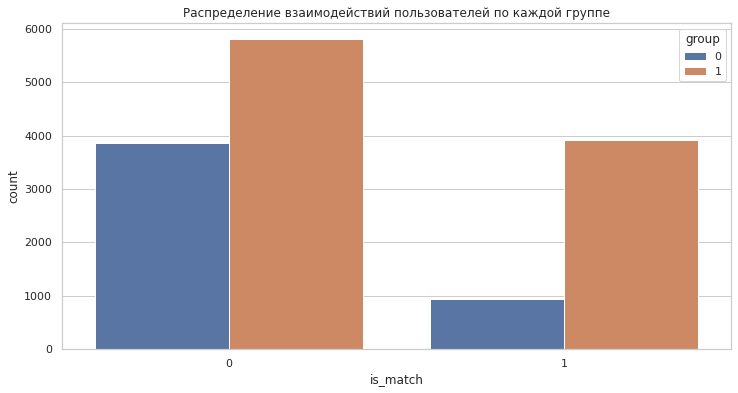

In [12]:
# посмотрим на графике

sns.countplot(data=df, x="is_match", hue="group")
plt.title('Распределение взаимодействий пользователей по каждой группе')
plt.show()

По графику видим, что влияние того или иного алгоритма есть. Но делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Так как мы имеем дело с двумя категориальными переменными, то будем использовать хи-квадрат.

Сформулируем нулевую гипотезу: 
 H<sub>0</sub>: взаимосвязи между переменными нет. 

Альтернативную гипотезу: 
 H<sub>1</sub>: взаимосвязь есть.

И зафиксируем уровень значимости **alpha = 0.05**

In [13]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.is_match, df.group))

In [14]:
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

In [15]:
print(output.format(stat, dof, p))

test Statistics: 618.6889141576197
degrees of freedom: 1
p-value: 1.441829916366341e-136



In [16]:
print(expected)

[[3193.01584677 6477.98415323]
 [1598.98415323 3244.01584677]]


In [17]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Значение p_value ниже 5%, мы отклоняем нулевую гипотезу и можем сделать вывод, что взаимосвязь между переменными есть. Посмотрим еще на общее количество анкет на пользователя.

In [23]:
n_profiles_per_user = df.groupby(["group", "user_id_1"], as_index=False).size()
n_profiles_per_user

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


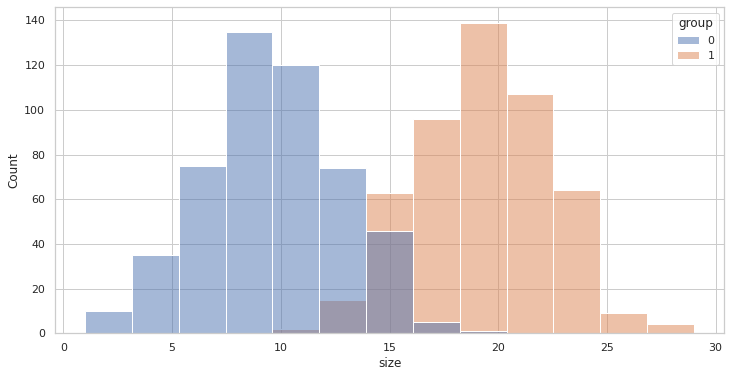

In [24]:
# на графике

sns.histplot(data=n_profiles_per_user, x="size", hue="group")

На графике видим, что число анкет на пользователя в группе 1 растет относительно числа анкет на пользователя группы 0. Проверим статистическую значимость различий количества анкет на пользователя между группами.

Сформулируем нулевую гипотезу: 
H<sub>0</sub>: Среднее число анкет на пользователя не изменилось.

Альтернативную гипотезу: 
H<sub>1</sub>: Среднее число анкет на пользователя изменилось.

Зафиксируем уровень значимости **alpha = 0.05**

Для сравнения средних в двух группах иcпользуем метод pg.ttest.

In [36]:
pg.ttest(x=n_profiles_per_user.query("group==0")["size"], 
         y=n_profiles_per_user.query("group==1")["size"]) #ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


Мы отвергаем гипотезу: различие в количестве анкет на пользователя для групп имеет статистически значимую разницу.

### Выводы

* Взаимосвязь между переменными есть, это статистически значимо подтверждается (значение p_value ниже 5%)
* Число анкет на пользователя в группе с новым алгоритмом выросло относительно числа анкет в группе со старым алгоритмом
* Новый алгоритм улучшил качество сервиса, и новую систему поиска анкет стоит включать для всех пользователей